In [1]:
import os, glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from ase.db import connect

from itertools import combinations

In [2]:
path = os.getcwd()
databases = sorted([n for n in os.listdir(path) if 'Cy' in n and n.endswith('.db')])
molnames = [n.split('_')[1][:-3] for n in databases]

molnames

['cc-Cy2', 'hc-Cy1', 'hc-Cy2', 'sc-Cy1', 'sc-mCy1']

In [3]:
def _get_refgeom_idx(dbpath, dbname):

    E0 = []
    for idx, mol in enumerate(connect(os.path.join(dbpath, dbname)).select()):
        #print(mol.data.keys())
        E0.append(mol.data['energy'][0][0])

    min_E0_idx = E0.index(min(E0))
    return min_E0_idx
    

In [4]:
Hartree2eV = 27.2114

In [5]:
def get_referenced_energies(dbpath, dbname):

    S0 = []
    S1 = []
    S2 = []
    for idx, mol in enumerate(connect(os.path.join(dbpath, dbname)).select()):
        S0.append(mol.data['energy'][0][0])
        S1.append(mol.data['energy'][0][1])
        S2.append(mol.data['energy'][0][2])

    Emin = np.min(S0)

    S0_ref = [(i - Emin)*27.2114 for i in S0]
    S1_ref = [(i - Emin)*27.2114 for i in S1]
    S2_ref = [(i - Emin)*27.2114 for i in S2]

    return S0_ref, S1_ref, S2_ref

In [6]:
def get_forbenius_normed_forces(dbpath, dbname):

    S0 = []
    S1 = []
    S2 = []
    for idx, mol in enumerate(connect(os.path.join(dbpath, dbname)).select()):
        S0.append(mol.data['forces'][:,:,0])
        S1.append(mol.data['forces'][:,:,1])
        S2.append(mol.data['forces'][:,:,2])

    #print(S0[0].shape)
    S0_norm = [np.linalg.norm(M, ord='fro') for M in S0]
    S1_norm = [np.linalg.norm(M, ord='fro') for M in S1]
    S2_norm =[ np.linalg.norm(M, ord='fro') for M in S2]

    return S0_norm, S1_norm, S2_norm

In [7]:
energy_data = []
forces_data = []

for idx, dbname in enumerate(databases):

    E0, E1, E2 = get_referenced_energies(path, dbname)
    tmp_energies = {
        'molecule': molnames[idx],
        'S$_0$': E0,
        'S$_1$': E1,
        'S$_2$': E2
    }
    energy_data.append(tmp_energies)

    F0, F1, F2 = get_forbenius_normed_forces(path, dbname)
    tmp_forces = {
            'molecule': molnames[idx],
            'S$_0$': F0,
            'S$_1$': F1,
            'S$_2$': F2
        }
    forces_data.append(tmp_forces)


In [20]:
len(energy_data[0]['S$_0$'])

1110

## Merge all energies for S0, S1 and S2 in one dict (rel. energies for each molecule)

In [58]:
#merge_energies = {key: [l_0.extend(entry[key]) for entry in energy_data if key != 'molecule'][0] for key in ['S$_0$', 'S$_1$', 'S$_2$']}
merge_forces = {key: [entry[key] for entry in forces_data if key != 'molecule'][0] for key in ['S$_0$', 'S$_1$', 'S$_2$']}

In [63]:
merge_keys = {'S$_0$': [], 'S$_1$': [], 'S$_2$': []}

merge_energies = {key: [value for entry in energy_data if key in entry and key != 'molecule' for value in entry[key]] for key in merge_keys}
merge_forces = {key: [value for entry in forces_data if key in entry and key != 'molecule' for value in entry[key]] for key in merge_keys}


In [69]:
len(merge_forces['S$_0$']), len(merge_forces['S$_1$']), len(merge_forces['S$_2$'])

(5545, 5545, 5545)

In [74]:
np.min(merge_forces['S$_0$']), np.max(merge_forces['S$_0$'])
np.min(merge_forces['S$_2$']), np.max(merge_forces['S$_2$'])

(0.0037574673909276262, 1.273745901466808)

## Merge Frobenius normed Forces of S0, S1 and S2 into one dict 

## Plot Energy and Force distribution

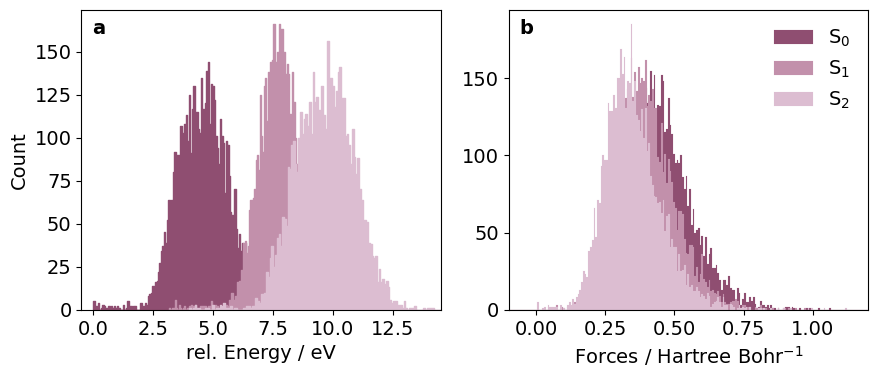

In [119]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# Set the global font size
_fs = 14
matplotlib.rcParams['font.size'] = _fs

fig = plt.figure(figsize=(9.0, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1])

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

cpurple0  = (143/255, 78/255, 113/255)
cpurple1  = (194/255, 144/255, 171/255)
cpurple2  = (220/255, 189/255, 209/255)

df_energies = pd.DataFrame(merge_energies)
df_forces   = pd.DataFrame(merge_forces)

# Create a combined histogram plot
sns.histplot(data=df_energies['S$_0$'], bins=150, kde=False, multiple='layer', label='S$_0$',
             element="step", stat='count',  #stat="density",
             facecolor=cpurple0, edgecolor=cpurple0, color=cpurple0, ax=ax1)

sns.histplot(data=df_energies['S$_1$'], bins=150, kde=False, multiple='layer', label='S$_1$',
             element="step", stat='count',  #stat="density",
             facecolor=cpurple1, edgecolor=cpurple1, color='black', ax=ax1)

sns.histplot(data=df_energies['S$_2$'], bins=150, kde=False, multiple='layer', label='S$_2$',
             element="step", stat='count', #stat="density",
             facecolor=cpurple2, edgecolor=cpurple2, color='black', ax=ax1)

ax1.text(0.03,0.97, 'a', transform=ax1.transAxes, color='black', fontsize=_fs, verticalalignment='top', 
         bbox=dict(facecolor='white', edgecolor='none', alpha=0.0),  weight='bold')
# Set labels and title for ax1
ax1.set_xlim(-0.5, 14.5)
ax1.set_xlabel('rel. Energy / eV')
ax1.set_ylabel('Count')
#ax1.legend(frameon=False)

# Create a combined histogram plot
sns.histplot(data=df_forces['S$_0$'], bins=250, kde=False, multiple='layer', label='S$_0$',
             binrange=[-0.1,1.5], 
             facecolor=cpurple0, edgecolor=cpurple0, 
             #facecolor='white', edgecolor='white', 
             element="bars", #stat='density',
             stat="count",
             color=cpurple0, ax=ax2)

sns.histplot(data=df_forces['S$_1$'], bins=250, kde=False, multiple='layer', label='S$_1$',
             binrange=[-0.1,1.5], 
             facecolor=cpurple1, edgecolor=cpurple1, 
             #facecolor='white', edgecolor='white', 
             element="bars", stat='count', 
             #stat="density", #stat='percent',  
             color=cpurple1, ax=ax2)

sns.histplot(data=df_forces['S$_2$'], bins=250, kde=False, multiple='layer', label='S$_2$',
             binrange=[-0.1,1.5], 
             facecolor=cpurple2, edgecolor=cpurple2, 
             #facecolor='white', edgecolor='white', 
             element="bars", stat='count', 
             #stat="density",
             color=cpurple2, ax=ax2)


ax2.text(0.03,0.97, 'b', transform=ax2.transAxes, color='black', fontsize=_fs, verticalalignment='top', 
         bbox=dict(facecolor='white', edgecolor='none', alpha=0.0),  weight='bold')
# Set labels and title for ax2
ax2.set_xlim(-0.1, 1.2)
ax2.set_xlabel('Forces / Hartree Bohr$^{-1}$')
ax2.set_ylabel('')
ax2.legend(frameon=False)

# Adjust layout
plt.tight_layout()

# Show the plot
#plt.show()
plt.savefig('Energy_Forces_space.pdf')